In [1]:
# import relevant libraries
# get Python 3's floor division feature (so that 5/2 = 2.5 and not 2)
from __future__ import division

# linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# libraries needed to build our web scraper
import re
from time import sleep
import requests
from bs4 import BeautifulSoup

In [2]:
# get the html text from the page we want to scrape
html = requests.get('http://www.albumoftheyear.org/ratings/6-highest-rated/all/1').text

In [3]:
# create a BeautifulSoup object with it
soup = BeautifulSoup(html, 'html.parser')

In [4]:
# get artist and album name
artist_album = [x.text for x in soup.find_all('span', itemprop='name')]
artist = pd.Series(artist_album).str.split(' - ').apply(lambda x: x[0])
album = pd.Series(artist_album).str.split(' - ').apply(lambda x: x[1])

In [5]:
# get the release date and split it by year, month and day
date = [x.text for x in soup.find_all('div', attrs={'class':'albumListDate'})]
month = pd.Series(date).str.extract('(\w+)\s\d+,\s\d+')
day = pd.Series(date).str.extract('\w+\s(\d+),\s\d+')
year = pd.Series(date).str.extract('\w+\s\d+,\s(\d+)')

C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app
C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [174]:
# get the scores
score = [x.text for x in soup.find_all('div', attrs={'class':'listScoreValue'})]

In [7]:
# get the number of reviews for each album
n_reviews = [x.text for x in soup.find_all('div', attrs={'class':'listScoreText'})]
n_reviews = pd.Series(n_reviews).str.extract('^(\d+)\s\w+')

C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [8]:
# getting the genres is a bit trickier because of the way that the html is written
genres = []
for d in soup.find_all('div', attrs={'class':'albumListDetails'}):
    for link in d.find_all('a'):
        genres.append(link.get_text())
        
genres = pd.Series(genres).str.replace(';', '')

In [176]:
# put all the data we've collected into one list
list_ = zip(artist, album, genres, year, month, day, score, n_reviews)

df = pd.DataFrame(list_, columns=[
        'artist', 'album', 'genre', 'year', 'month', 'day', 'score', 'n_reviews'
    ])

df

,artist,album,genre,year,month,day,score,n_reviews
0,Prince,"Sign ""O"" the Times",R&B,1987,March,31,100,6
1,The Replacements,Let It Be,Alternative Rock,1984,October,2,100,6
2,Paul Simon,Graceland,Singer-Songwriter,1986,August,12,100,5
3,Joni Mitchell,Court and Spark,Folk,1974,January,1,100,5
4,Miles Davis,Kind of Blue,Jazz,1959,August,17,100,5
5,The Stone Roses,The Stone Roses,Alternative Rock,1989,March,13,100,5
6,Pixies,Doolittle,Alternative Rock,1989,April,18,100,5
7,The Beatles,Revolver,Pop Rock,1966,August,5,100,5
8,R.E.M.,Automatic for the People,Alternative Rock,1992,October,5,100,5
9,The Beatles,Rubber Soul,Pop Rock,1965,December,3,100,5


In [116]:
# now that we know how to get all the information we want from one page, let's create a function
# that scrapes all the pages
frames = []

def scrape_aoty(page):
    """Scrapes albumoftheyear.org to get the full list of the best 500 albums of all time.
    Parameters
    ----------
    page : int
        Page number (e.g. 1, 2, 3, ..., 20). To scrape the whole list, iterate over 
        range(1, 21).
    """
    
    html = requests.get('http://www.albumoftheyear.org/ratings/6-highest-rated/all/' + str(page) + '?r=10').text
    
    soup = BeautifulSoup(html, 'html.parser')
    
    artist_album = [x.text for x in soup.find_all('span', itemprop='name')]
    artist = pd.Series(artist_album).str.split(' - ').apply(lambda x: x[0])
    album = pd.Series(artist_album).str.split(' - ').apply(lambda x: x[1])
    
    date = [x.text for x in soup.find_all('div', attrs={'class':'albumListDate'})]
    month = pd.Series(date).str.extract('(\w+)\s\d+,\s\d+')
    day = pd.Series(date).str.extract('\w+\s(\d+),\s\d+')
    year = pd.Series(date).str.extract('\w+\s\d+,\s(\d+)')
    
    score = [x.text for x in soup.find_all('div', attrs={'class':'listScoreValue'})]

    n_reviews = [x.text for x in soup.find_all('div', attrs={'class':'listScoreText'})]
    n_reviews = pd.Series(n_reviews).str.extract('^(\d+)\s\w+')
    
    genres = []
    
    for d in soup.find_all('div', attrs={'class':'albumListDetails'}):
        for link in d.find_all('a'):
            genres.append(link.get_text())

    genres = pd.Series(genres).str.replace(';', '')
    
    dctnry = zip(artist, album, genres, year, month, day, score, n_reviews)

    df = pd.DataFrame(dctnry, columns=[
        'artist', 'album', 'genre', 'year', 'month', 'day', 'score', 'n_reviews'
    ])

    frames.append(df)

In [117]:
# scrape it all!
for i in range(1, 21):
    scrape_aoty(i)

C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
C:\Users\aluz\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: currently extract(expand=None) means expand=False (return I

In [134]:
final = pd.concat(frames)

In [135]:
# it looks like it worked, we have the 500 albums
final.shape

(500, 8)

In [136]:
# check the data types for each column and change if needed
final.dtypes

artist       object
album        object
genre        object
year         object
month        object
day          object
score        object
n_reviews    object
dtype: object

In [137]:
final.score = final.score.astype('int')
final.n_reviews = final.n_reviews.astype('int')

In [138]:
#final.to_csv('../datasets/AOTY.csv', index=False, encoding='utf-8')

In [139]:
# create a new column that takes into account both the AOTY.org score but also how many publications reviewed the album
# because we want an album with a score of 92 and 30 reviews to appear higher in our list than an album with a 
# score of 96 and only 3 reviews
# giving 3 times more importance to the score than to the number of reviews seems to result in a nice equilibrium 
final['avg_score'] = 3 * final.score + final.n_reviews

In [140]:
# top 20 albums of all time. I can see some personal favourites in there but... where's Is This It by The Strokes?!
final.sort_values('avg_score', ascending=False).head(20).reset_index(drop=True)

,artist,album,genre,year,month,day,score,n_reviews,avg_score
0,Kendrick Lamar,To Pimp a Butterfly,Hip Hop,2015,March,16,94,30,312
1,Kanye West,My Beautiful Dark Twisted Fantasy,Hip Hop,2010,November,22,92,33,309
2,Frank Ocean,Channel Orange,R&B,2012,July,17,92,30,306
3,D'Angelo,Black Messiah,Neo-Soul,2014,December,15,93,23,302
4,Arcade Fire,Funeral,Indie Rock,2004,September,14,96,14,302
5,Sufjan Stevens,Carrie & Lowell,Indie Folk,2015,March,31,90,31,301
6,Animal Collective,Merriweather Post Pavilion,Experimental,2009,January,20,91,27,300
7,Sleater-Kinney,No Cities to Love,Indie Rock,2015,January,20,90,27,297
8,Father John Misty,"I Love You, Honeybear",Singer-Songwriter,2015,February,10,89,29,296
9,My Bloody Valentine,m b v,Shoegaze,2013,February,3,89,29,296


In [177]:
# there it is! definitely being penalised due to a low number of reviews (2001 was a long time ago!)
final.loc[final.album == 'Is This It', :]

,artist,album,genre,year,month,day,score,n_reviews,avg_score
1,The Strokes,Is This It,Alternative Rock,2001,October,9,88,10,274


In [181]:
# let's create a list with the 3 most popular genres
top_genres = final.genre.value_counts().head(3).index

In [182]:
# let's see which genre has the highest avg_score
# Hip Hop... I'm sure Kanye West and Kendrick Lamar have something to do with it
final.loc[final.genre.isin(top_genres), :]\
.groupby('genre').avg_score.mean().sort_values(ascending=False)

genre
Hip Hop       267.596154
Electronic    266.862069
Indie Rock    265.434211
Name: avg_score, dtype: float64

In [143]:
# let's look for seasonal trends. we'll need to convert our month column to a category and define its order
# so the x axis makes sense in our charts
final.month = final.month.astype('category')

In [144]:
final.month.cat.reorder_categories(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',\
                                    'September', 'October', 'November', 'December'], ordered=True, inplace=True)

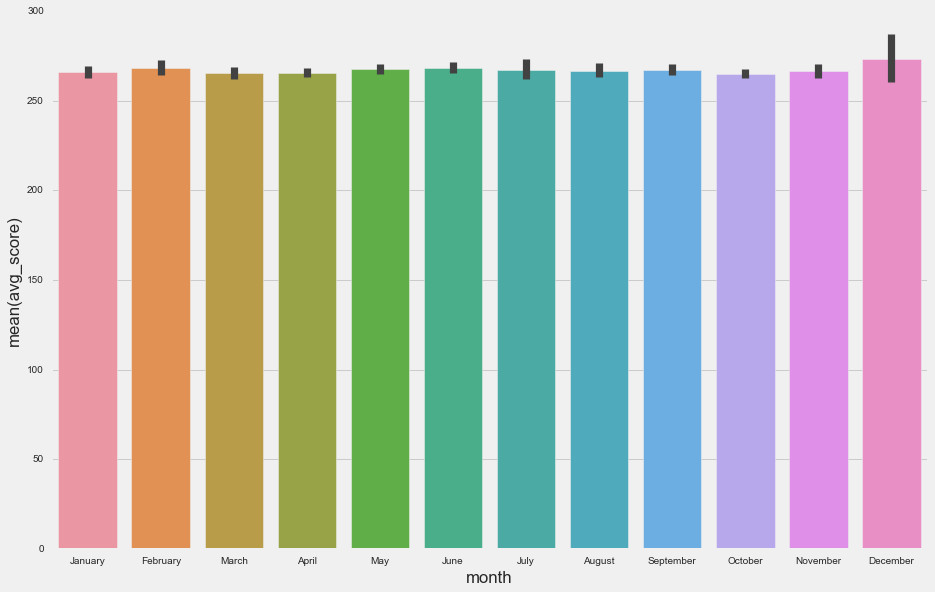

In [145]:
# all months looks the same because remember this is a list of the best albums, not all albums!
plt.figure(figsize=(14, 9))
sns.barplot(final.month, final.avg_score)

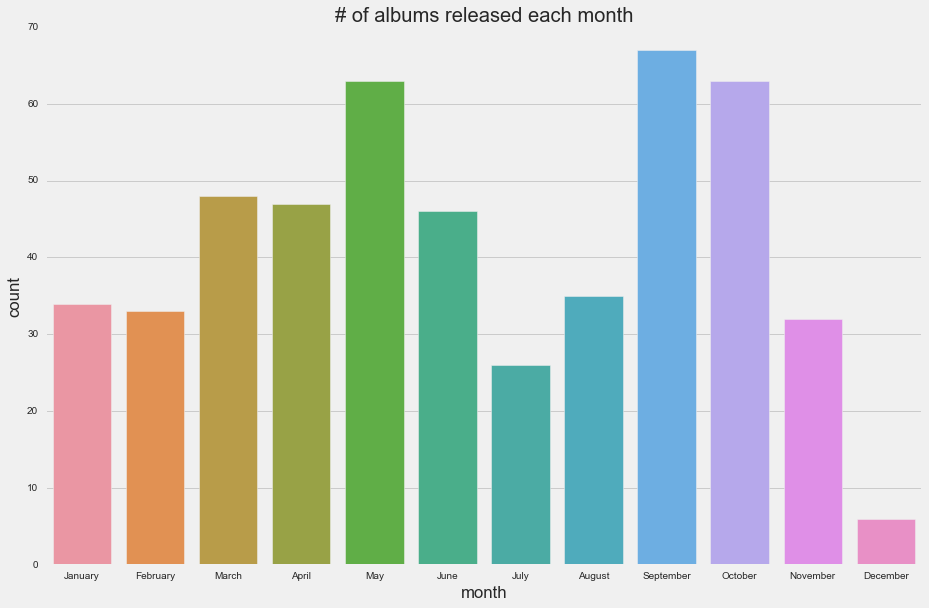

In [125]:
# September, October and May are the busiest months in terms of (great) album releases
# Followed by the rest of Q2 and March
plt.figure(figsize=(14, 9))
sns.countplot(final.month)
plt.title('# of albums released each month')

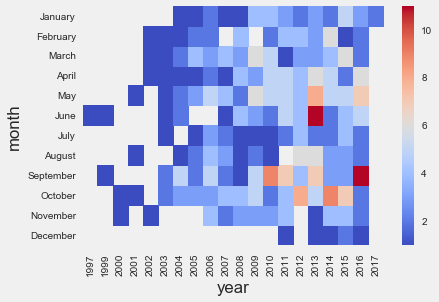

In [126]:
# most popular months, broken up by year 
# another way of seeing that May-June and September-October tend to be the busiest months
# December it's always been the month with a lower number of album releases (well, of good albums at least!)
sns.heatmap(final.pivot_table(index='month', columns='year', aggfunc='count').artist, cmap='coolwarm')

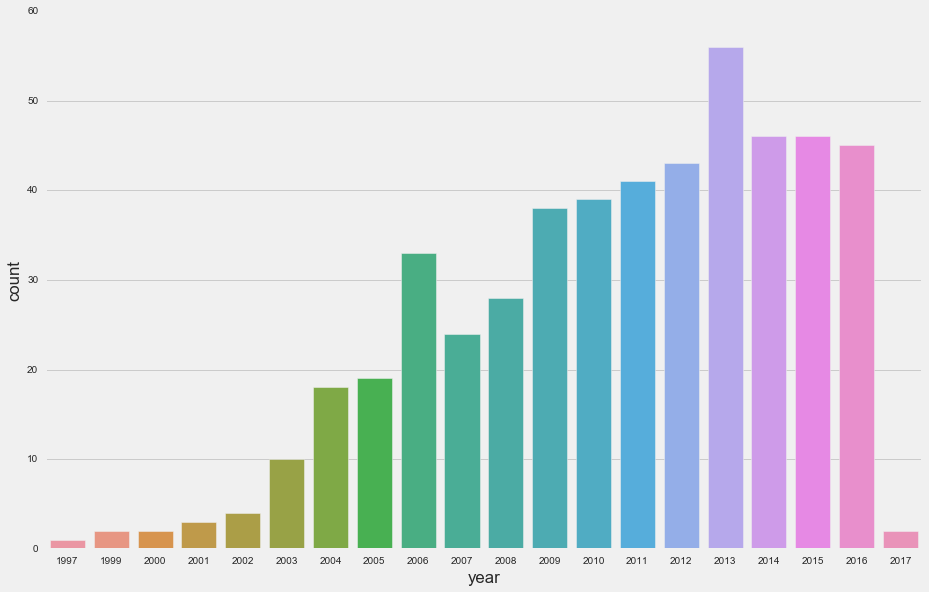

In [63]:
# this probably has to do with albumoftheyear.org being a modern website
# they've spent some time collecting older reviews, but it's clear their focus is on current releases
# nevertheless, 2013 and 2006 seem to have been particularly good years for music
plt.figure(figsize=(14, 9))
sns.countplot(final.year)

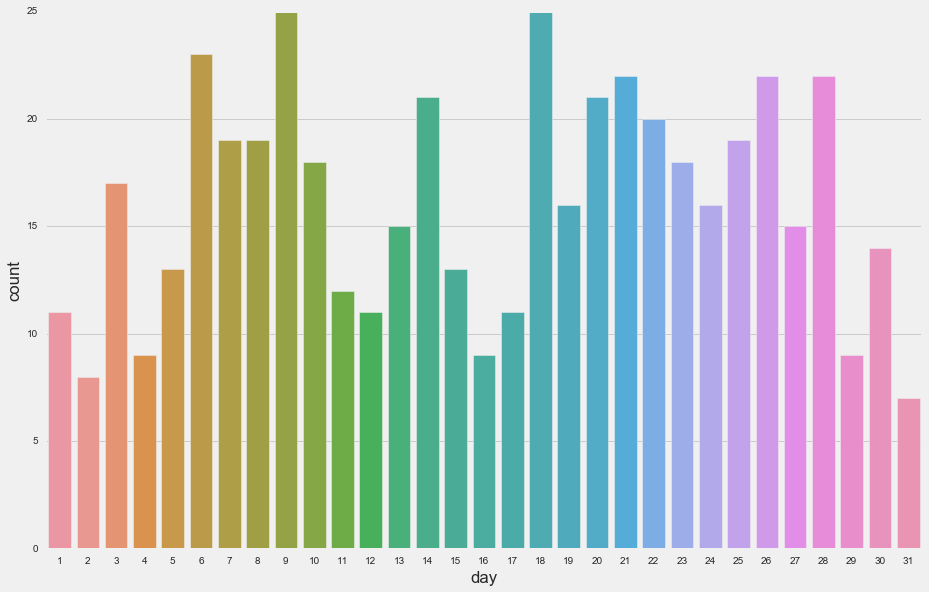

In [68]:
# there are fewer releases in the first and last days of the month, as well as mid-month
plt.figure(figsize=(14, 9))
sns.countplot(final.day.astype('int'))

In [160]:
# let's look at what albums were released in 2006 and 2013 to see what were the great releases
# we can see Arctic Monkeys and Beirut's debut albums in 2006, while in 2013 we had the returns of
# My Bloody Valentine and Daft Punk, together with new albums from Vampire Weekend, Kanye West and... Arctic Monkeys!
# could we conclude then that Arctic Monkeys releasing an album causes other bands to release great albums? NO!
pd.set_option('max_rows', None)
final.loc[final.year.isin(['2006', '2013']), :].sort_values(['year', 'avg_score'], ascending=[True, False])\
.reset_index(drop=True)

,artist,album,genre,year,month,day,score,n_reviews,avg_score
0,Bob Dylan,Modern Times,Folk,2006,August,29,90,13,283
1,TV on the Radio,Return to Cookie Mountain,Experimental Rock,2006,September,12,88,17,281
2,Clipse,Hell Hath No Fury,Hip Hop,2006,November,28,89,13,280
3,Joanna Newsom,Ys,Indie Folk,2006,November,14,86,21,279
4,Destroyer,Destroyer's Rubies,Indie Rock,2006,February,21,87,11,272
5,The Hold Steady,Boys and Girls in America,Rock,2006,October,3,86,13,271
6,Tom Waits,"Orphans: Brawlers, Bawlers & Bastards",Blues,2006,November,21,86,12,270
7,Ghostface Killah,Fishscale,Hip Hop,2006,March,28,86,10,268
8,Herbert,Scale,House,2006,May,29,86,10,268
9,The Decemberists,The Crane Wife,Folk Rock,2006,October,3,84,16,268


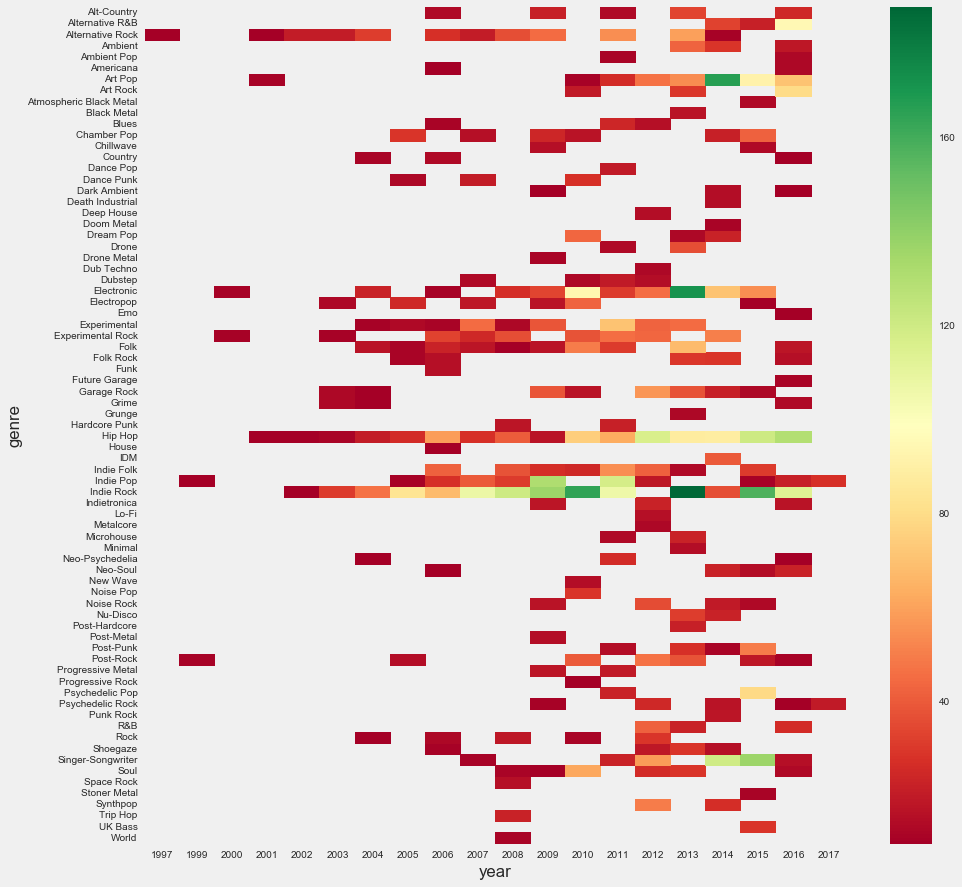

In [173]:
# here we can see the Indie Rock boom from 2007 onwards as well as the increasing prominence of Hip Hop albums
# topping end-of-year lists
plt.figure(figsize=(14,14))
sns.heatmap(final.pivot_table(values='n_reviews', index='genre', columns='year', aggfunc='sum'), cmap='RdYlGn')